In [48]:
import sys
sys.path.append('../')

from scripts.direct_training import direct_training
import matplotlib.pyplot as plt
from plotting_utils import style_defaults
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(style_defaults)

direct_df = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-GAP-17",
        labels="dft"
    ),
    include_metadata=True,
).sort_values(by="n_train").reset_index(drop=True)

direct_df = direct_df[["n_train", "metadata_timing_training_duration", "test_force_rmse"]]
direct_df.columns = ["n_train", "duration", "test_force_rmse"]


# get slowest and fasetest models
fastest_models = direct_df.groupby("n_train")["duration"].idxmin()
slowest_models = direct_df.groupby("n_train")["duration"].idxmax()

fastest_direct_df = direct_df.loc[fastest_models].reset_index(drop=True)
slowest_direct_df = direct_df.loc[slowest_models].reset_index(drop=True)

# plot mean times
direct_df = direct_df.groupby("n_train").mean().reset_index()

direct_df

,n_train,duration,test_force_rmse
0,25,119.348213,1.272320
1,50,172.919161,1.169301
2,100,210.127797,1.046646
3,200,347.751224,0.960221
4,400,671.196331,0.899739
5,800,1562.821823,0.828033
6,1600,3521.671958,0.766070
7,3200,10121.660120,0.709253


In [70]:
fastest_direct_df

,n_train,duration,test_force_rmse
0,25,91.136917,1.329822
1,50,109.893270,1.138545
2,100,143.819512,1.074188
3,200,245.618072,0.971323
4,400,410.263450,0.894192
5,800,890.060217,0.836462
6,1600,2219.908514,0.770546
7,3200,6496.317693,0.711813


In [71]:
slowest_direct_df

,n_train,duration,test_force_rmse
0,25,154.957026,1.231181
1,50,359.398669,1.162157
2,100,390.821763,1.038846
3,200,574.255407,0.954907
4,400,1004.050293,0.901780
5,800,2651.073212,0.824954
6,1600,5434.435193,0.766375
7,3200,15991.228586,0.707432


In [49]:
from scripts.fine_tuning import fine_tuning

pt_model = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-SYNTH-23M:reasonable",
        n_train=100_000,
        labels="ace"
    ),
).iloc[0].id

finetune_df = fine_tuning.to_dataframe(
    config=dict(
        pretrain_id=pt_model,
    ),
    include_metadata=True,
).sort_values(by="n_finetune")

finetune_df = finetune_df[["n_finetune", "metadata_timing_training_duration", "test_force_rmse"]]
finetune_df.columns = ["n_finetune", "duration", "test_force_rmse"]

finetune_df

,n_finetune,duration,test_force_rmse
0,25,35.336251,0.841699
1,50,37.589289,0.818326
2,100,56.698589,0.785320
3,200,98.617574,0.758818
4,400,182.246408,0.738471
5,800,373.184065,0.719071
6,1600,849.403731,0.702190
7,3200,1859.107319,0.680747


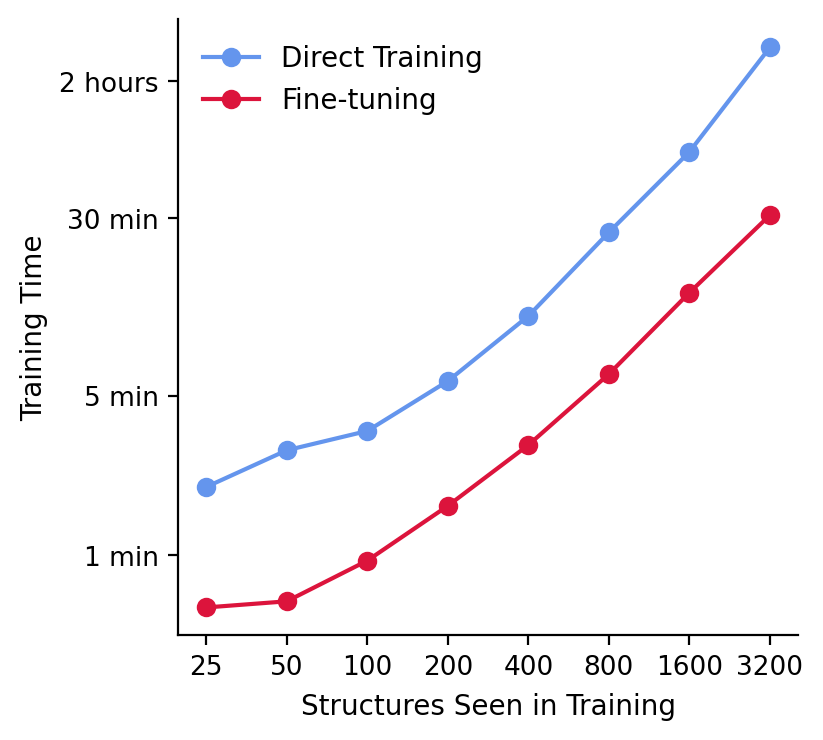

In [50]:
plt.plot(
    direct_df.n_train,
    direct_df.duration / 60,
    "-o",
    c="cornflowerblue",
    label="Direct Training"
)

plt.plot(
    finetune_df.n_finetune,
    finetune_df.duration / 60,
    "-o",
    c="crimson",
    label="Fine-tuning"
)
plt.xscale("log")
plt.xticks(finetune_df.n_finetune, finetune_df.n_finetune)
plt.xlabel("Structures Seen in Training")

yticks = [1, 5, 30, 120]
plt.yscale("log")
plt.yticks(yticks, ["1 min", "5 min", "30 min", "2 hours"])
plt.ylabel("Training Time")

plt.legend()
plt.minorticks_off()

In [51]:
speedup = (direct_df.duration / finetune_df.duration).mean()

f"On average, fine-tuning provides a {speedup:.1f}x speedup over direct training."

'On average, fine-tuning provides a 4.1x speedup over direct training.'

In [63]:
# fastest and slowest models

print("For a given number of structures seen in training, fine-tuning is:")

speedup = (fastest_direct_df.duration / finetune_df.duration).mean()
print(f"\t{speedup:.1f}x faster than the fastest direct training model.")

speedup = (slowest_direct_df.duration / finetune_df.duration).mean()
print(f"\t{speedup:.1f}x faster than the slowest direct training model.")

For a given number of structures seen in training, fine-tuning is:
	2.7x faster than the fastest direct training model.
	6.8x faster than the slowest direct training model.


In [67]:
# average iso-loss speed up
speedup = (
    direct_df[direct_df.n_train == 800].duration.values
    / finetune_df[finetune_df.n_finetune == 25].duration.values
).item()

print(
    "For a model with a given test force RMSE, "
    f"fine-tuning is {speedup:.0f}x faster than direct training on average."
)

For a model with a given test force RMSE, fine-tuning is 44x faster than direct training on average.


In [68]:
# range of iso-loss speed up
least = (
    fastest_direct_df[fastest_direct_df.n_train == 800].duration.values
    / finetune_df[finetune_df.n_finetune == 25].duration.values
).item()

most = (
    slowest_direct_df[slowest_direct_df.n_train == 800].duration.values
    / finetune_df[finetune_df.n_finetune == 25].duration.values
).item()

print(f"The above average falls in the range of {least:.0f}x to {most:.0f}x.")

The above average falls in the range of 25x to 75x.


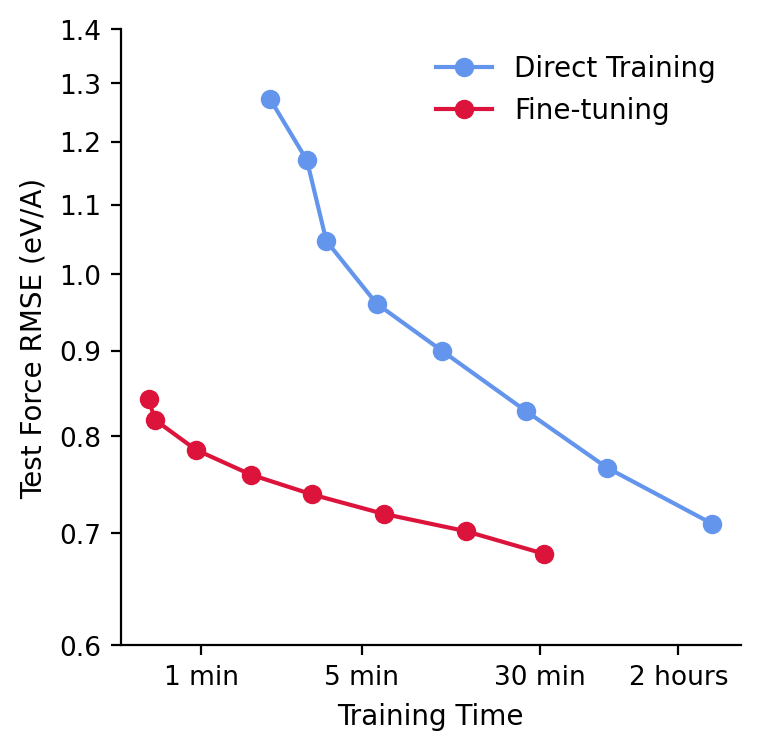

In [69]:
# also plot speed of training vs accuracy

plt.plot(
    direct_df.duration / 60,
    direct_df.test_force_rmse,
    "-o",
    c="cornflowerblue",
    label="Direct Training"
)

plt.plot(
    finetune_df.duration / 60,
    finetune_df.test_force_rmse,
    "-o",
    c="crimson",
    label="Fine-tuning"
)

plt.xscale("log")
plt.xticks([1, 5, 30, 120], ["1 min", "5 min", "30 min", "2 hours"])

yticks = [round(y, 1) for y in plt.yticks()[0]]
plt.yscale("log")
plt.yticks(yticks, yticks)

plt.xlabel("Training Time")
plt.ylabel("Test Force RMSE (eV/A)")
plt.legend()
plt.minorticks_off()